In [1]:
import DelimitedFiles
import DPFEHM
import PyPlot
using Statistics

In [2]:
function addfractures!(logks, fracture_logk, fracture_scales; beta=0.5)
	#this recursively defines a formula where fracture_logk ∝ length ^ beta as in equation 5 from Jeffrey's paper (10.1002/2016WR018806)
	if fracture_scales > 0
		if fracture_logk < 0.0
			@show fracture_logk
			@show fracture_scales
			error("you need to increase fracture_logk so that the permeability of the small fractures is greater than the permeability of the matrix")
		end
		logks[div(end, 2), 1:div(3 * end, 4) + 1] .= fracture_logk + log(1.5 ^ beta)#this fracture is 1.5 times longer than the next fracture
		logks[div(end, 4):div(3 * end, 4), div(end, 2)] .= fracture_logk
		n = size(logks, 1)
		#addfractures!(view(logks, 1:div(n, 2), 1:div(n, 2)))#upper left
		addfractures!(view(logks, 1:div(n, 2), div(n, 2) + 1:n), fracture_logk - log(2 ^ beta), fracture_scales - 1; beta=beta)#upper right
		#addfractures!(view(logks, div(n, 2) + 1:n, 1:div(n, 2)))#lower left
		addfractures!(view(logks, div(n, 2) + 1:n, div(n, 2) + 1:n), fracture_logk - log(2 ^ beta), fracture_scales - 1; beta=beta)#lower right
	end
end
addboundaries(logks) = hcat(logks[:, 1], logks, logks[:, end])

function fractal_fractures(N, fracture_scales; doplot=false, matrix_logk=0.0, fracture_logk=1.0, kwargs...)
	mins = [0.0, 0.0]
	maxs = [1, 1]
	ns = [N + 2, N]
	xs = range(mins[1], maxs[1]; length=ns[1])
	ys = range(mins[2], maxs[2]; length=ns[2])
	logks = fill(matrix_logk, N, N)
	addfractures!(logks, fracture_logk, fracture_scales; kwargs...)
	logks = addboundaries(logks)
	if doplot
		fig, ax = PyPlot.subplots()
		img = ax.imshow(logks)
		fig.colorbar(img)
		display(fig)
		println()
		PyPlot.close(fig)
	end
	coords, neighbors, areasoverlengths, _ = DPFEHM.regulargrid2d(mins, maxs, ns, 1.0)
	logKs2Ks_neighbors(Ks) = exp.(0.5 * (Ks[map(p->p[1], neighbors)] .+ Ks[map(p->p[2], neighbors)]))
	Ks_neighbors = logKs2Ks_neighbors(logks)
	dirichletnodes = [collect(1:2 * N); collect(prod(ns) - 2 * N + 1:prod(ns))]
	dirichleths = zeros(size(coords, 2))
	dirichleths[1:2 * N] .= 1.0
	Qs = zeros(size(coords, 2))
	A = DPFEHM.groundwater_h(zeros(size(coords, 2) - length(dirichletnodes)), Ks_neighbors, neighbors, areasoverlengths, dirichletnodes, dirichleths, Qs, ones(size(coords, 2)), ones(size(coords, 2)))
	b = -DPFEHM.groundwater_residuals(zeros(size(coords, 2) - length(dirichletnodes)), Ks_neighbors, neighbors, areasoverlengths, dirichletnodes, dirichleths, Qs, ones(size(coords, 2)), ones(size(coords, 2)))
	x = A \ b
	isfreenode, nodei2freenodei, freenodei2nodei = DPFEHM.getfreenodes(prod(ns), dirichletnodes)
	h = DPFEHM.addboundaryconditions(x, dirichletnodes, dirichleths, isfreenode, nodei2freenodei)

	if doplot
		fig, axs = PyPlot.subplots(1, 2)
		axs[1].imshow(reshape(h, reverse(ns)...), origin="lower", extent=[mins[1], maxs[1], mins[2], maxs[2]])
		axs[2].imshow(reshape(h, reverse(ns)...) .- [1 - x for x in xs, y in ys]', origin="lower", extent=[mins[1], maxs[1], mins[2], maxs[2]])
		display(fig)
		println()
		PyPlot.close(fig)

		fig, ax = PyPlot.subplots()
		nx(n) = 0.5 * (coords[1, n[1]] + coords[1, n[2]])
		ny(n) = 0.5 * (coords[2, n[1]] + coords[2, n[2]])
		ax.scatter(map(nx, neighbors), map(ny, neighbors), c=Ks_neighbors, s=30, alpha=0.25)
		display(fig)
		println()
		PyPlot.close(fig)
	end
	return x, h, logks
end


fractal_fractures (generic function with 1 method)

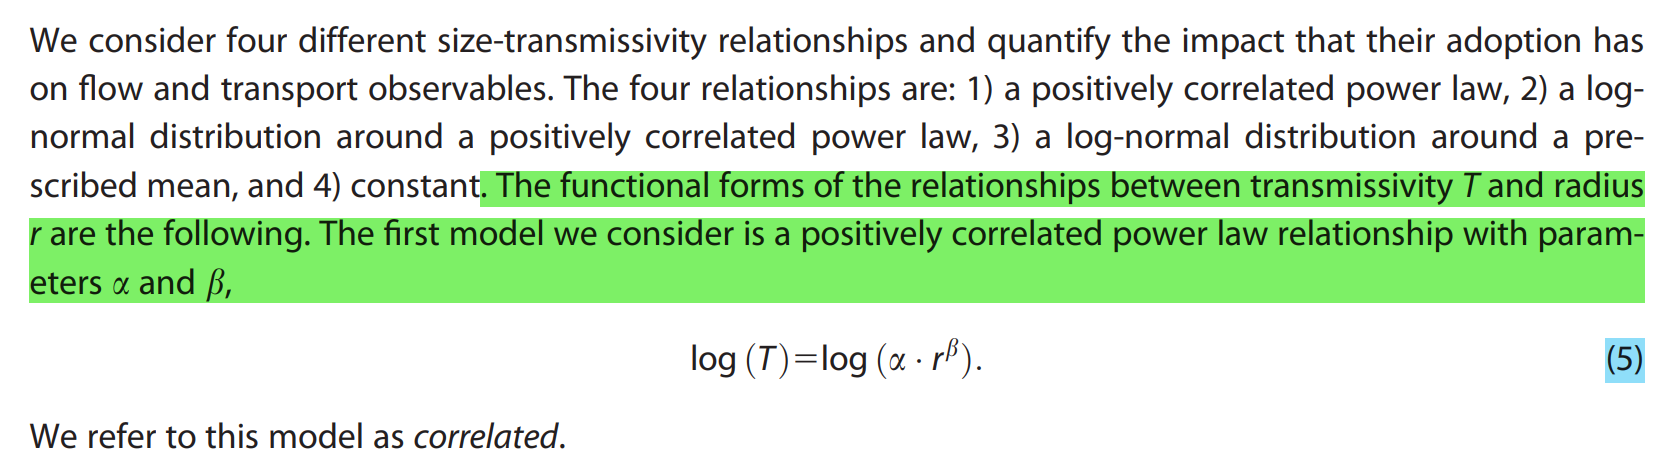

In [3]:
betas = collect(range(0.25, 0.75; length=2 ^ 8))        #  0.25, 0.75 / 2 ^ 6
fracture_logks = collect(range(1, 6; length=2 ^ 8))     #  1, 6
matrix_logks = collect(range(-7, 5; length=2 ^ 8))      # -7, 5
i = 1
j = 1
k = 1

# matrix perm should be lower than high end for fracture
# add_fractures() - this recursively defines a formula where fracture_logk ∝ length ^ beta as in equation 5 from Jeffrey's paper (10.1002/2016WR018806)
# perm of fracture = C_fract_logks r_fracture_length^beta
# matrix perm

# @time begin

#z = randn(length(x))
values = Float64[]
for i = 1:length(betas), j = 1:length(fracture_logks), k = 1:length(matrix_logks)
    x, h, logks = fractal_fractures(2 ^ 4, 2; matrix_logk=matrix_logks[k], fracture_logk=fracture_logks[j], beta=betas[i], doplot=false)
    matrix_k = exp(matrix_logks[k])
    #z = matrix_k * reshape(x, 16, 14)[:, end]
    z = zeros(16, 14)
    z[:, end] .= matrix_k
    z = z[:]
    z = z / sqrt(sum(z .^ 2))
    x = x / sqrt(sum(x .^ 2))
    value = sum(x .* z)
    value
    push!(values, value)
end
# DelimitedFiles.writedlm("values_b_0.25_0.75_f_1_6_m-7_5_2_24.csv", values, ',') #

# end

#=
for i = 4:7, fracture_scales = 1:i - 1
	A_with_fractures, x_with_fractures, b_with_fractures = fractal_fractures(2 ^ i, fracture_scales; fracture_logk=5.0, doplot=true)
end
=#
nothing



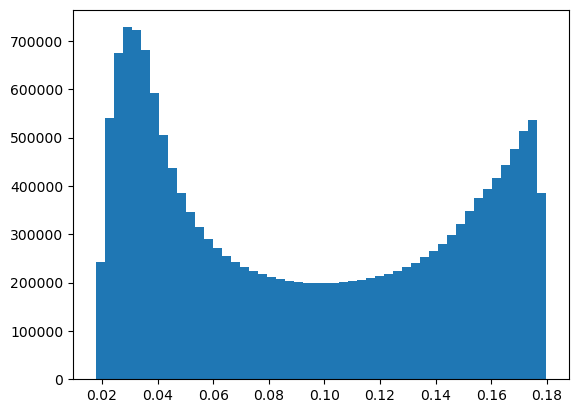

In [4]:
fig, ax = PyPlot.subplots()
ax.hist(values, bins=50)
display(fig)
println()
PyPlot.close(fig)

In [5]:
mean_value = mean(values)
variance_value = var(values)
# std_value = std(values)
println("Mean: $mean_value")
println("Variance: $variance_value")
# println("Standard Deviation: $std_value")

Mean: 0.0935205339781044
Variance: 0.0028739832248002753


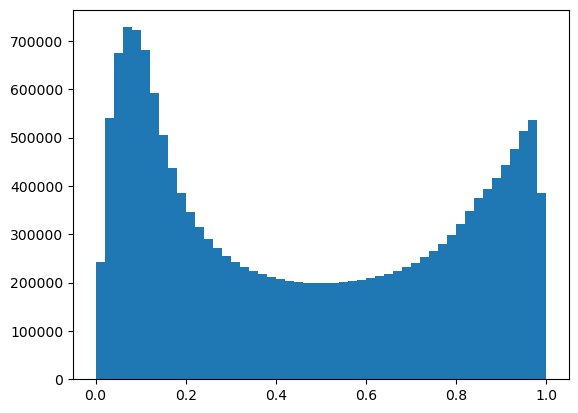

In [6]:
min_val = minimum(values)
max_val = maximum(values)
dif_max_min_val = max_val - min_val
values_norm = (values .- min_val) ./ dif_max_min_val

fig, ax = PyPlot.subplots()
ax.hist(values_norm, bins=50)
display(fig)
println()
PyPlot.close(fig)

In [7]:
mean_value = mean(values_norm)
variance_value = var(values_norm)
println("Mean: $mean_value")
println("Variance: $variance_value")

Mean: 0.4676791381334724
Variance: 0.10935801906740118
